In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Baseline STCB sweep
z_cb_lst = np.hstack((np.linspace(25, 350, 14), np.linspace(400, 750, 8)))
TS_cb_v2_lst = np.hstack(([0.56, 0.575], np.linspace(0.6, 1., 17)))
TS_cb_vmax_lst = np.linspace(0.475, 1., 22)

In [3]:
# Functions
pyna_settings = pyna.load_settings(case_name='stca')
pyna_settings.engine_file_name = "engine_deck_stca.csv"
py = pyna(pyna_settings)
py.engine.load_deck(py.settings)

T3_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['Tti_c'])
P3_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['Pti_c'])
Wf_interp = RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['W_f'])

def compute_EI(T3, P3):
    a = 6.25528852e-08
    b = -1.17064467e-04
    c = 7.36953400e-02
    d = -1.50392850e+01
    EI = (P3 / 1000.) ** 0.4 * (a * T3 ** 3 + b * T3 ** 2 + c * T3 + d)
    
    return EI

In [7]:
# Load data 
case_lst = ['v2', 'vmax']
trajectory_lst = ['stcb_base', 'stcb_adv', 'ptcb']#, 'phld']
traj = dict()
engine = dict()
data = dict()

for case in case_lst:

    # Load data
    if case == 'v2':

        traj[case] = dict()
        traj[case]['stcb_base'] = pd.read_csv('../cases/stca/trajectory/STCB/V2/Trajectory_stca_700.0_0.56.csv')
        traj[case]['stcb_adv'] = pd.read_csv('../cases/stca/trajectory/STCB/V2/Trajectory_stca_25.0_0.56.csv')
        traj[case]['ptcb'] = pd.read_csv('../cases/stca/trajectory/PTCB/V2_final/Trajectory_stca_ptcb_v2.csv')
#         traj[case]['phld'] = pd.read_csv('../cases/stca/trajectory/PHLD/V2_final/Trajectory_stca_phld_v2.csv')
        
        engine[case] = dict()
        engine[case]['stcb_base'] = pd.read_csv('../cases/stca/engine/STCB/V2/engine_stca_700.0_0.56.csv')
        engine[case]['stcb_adv'] = pd.read_csv('../cases/stca/engine/STCB/V2/engine_stca_25.0_0.56.csv')
        engine[case]['ptcb'] = pd.read_csv('../cases/stca/engine/PTCB/V2_final/engine_stca_ptcb_v2.csv')
#         engine[case]['phld'] = pd.read_csv('../cases/stca/engine/PHLD/V2_final/engine_stca_phld_v2.csv')
        
        data[case] = dict()
        data[case]['stcb_base'] = dict()
        data[case]['stcb_adv'] = dict()
        data[case]['ptcb'] = dict()
        data[case]['phld'] = dict()
        
    elif case == 'vmax':
        
        traj[case] = dict()
        traj[case]['stcb_base'] = pd.read_csv('../cases/stca/trajectory/STCB/Vmax/Trajectory_stca_600.0_0.48.csv')
        traj[case]['stcb_adv'] = pd.read_csv('../cases/stca/trajectory/STCB/Vmax/Trajectory_stca_25.0_0.55.csv')
        traj[case]['ptcb'] = pd.read_csv('../cases/stca/trajectory/PTCB/Vmax_final/Trajectory_stca_ptcb_vmax.csv')
#         traj[case]['phld'] = pd.read_csv('../cases/stca/trajectory/PHLD/Vmax/Trajectory_stca_phld_vmax.csv')
        
        engine[case] = dict()
        engine[case]['stcb_base'] = pd.read_csv('../cases/stca/engine/STCB/Vmax/engine_stca_600.0_0.48.csv')
        engine[case]['stcb_adv'] = pd.read_csv('../cases/stca/engine/STCB/Vmax/engine_stca_25.0_0.55.csv')
        engine[case]['ptcb'] = pd.read_csv('../cases/stca/engine/PTCB/Vmax_final/engine_stca_ptcb_vmax.csv')
#         engine[case]['phld'] = pd.read_csv('../cases/stca/engine/PHLD/Vmax/engine_stca_phld_vmax.csv')
        
        data[case] = dict()
        data[case]['stcb_base'] = dict()
        data[case]['stcb_adv'] = dict()
        data[case]['ptcb'] = dict()
        data[case]['phld'] = dict()
        

In [8]:
# Compute emissions for certification cycle
cert = dict()

TS_lst = [0.85, 0.65]
time_lst = [2.2, 2.0]
for i, case in enumerate(['subsonic', 'supersonic']):
    cert[case] = dict()

    cert[case]['Tt3'] = T3_interp((0, 0, TS_lst[i]))
    cert[case]['Pt3'] = P3_interp((0, 0, TS_lst[i]))
    cert[case]['W_f'] = Wf_interp((0, 0, TS_lst[i]))
    cert[case]['EI'] = compute_EI(cert[case]['Tt3'], cert[case]['Pt3'])

    cert[case]['mnox'] = time_lst[i]*60*cert[case]['EI']*cert[case]['W_f']
    

In [9]:
# Compute emissions for trajectories
mnox = dict()
TSavg = dict()
tclimb = dict()

for case in case_lst:
    mnox[case] = np.zeros(6)
    TSavg[case] = np.zeros(6)
    tclimb[case] = np.zeros(6)
    
    for j, t_name in enumerate(trajectory_lst):
        z  = traj[case][t_name]['Z [m]']
        M0 = traj[case][t_name]['M_0 [-]']
        TS = traj[case][t_name]['TS [-]']

        data[case][t_name]['Tt3'] = np.zeros(np.size(z))
        data[case][t_name]['Pt3'] = np.zeros(np.size(z))
        data[case][t_name]['Wf'] = np.zeros(np.size(z))
        data[case][t_name]['EINOx'] = np.zeros(np.size(z))
        data[case][t_name]['mdot_NOx'] = np.zeros(np.size(z))
        
        for i in np.arange(np.size(z)):
            data[case][t_name]['Tt3'][i] = T3_interp((np.max((0,z[i])), M0[i], TS[i]))
            data[case][t_name]['Pt3'][i] = P3_interp((np.max((0,z[i])), M0[i], TS[i]))
            data[case][t_name]['Wf'][i] =  Wf_interp((np.max((0,z[i])), M0[i], TS[i]))
    
            a = 6.25528852e-08
            b = -1.17064467e-04
            c = 7.36953400e-02
            d = -1.50392850e+01
            data[case][t_name]['EINOx'][i] = compute_EI(data[case][t_name]['Tt3'][i], data[case][t_name]['Pt3'][i])
            data[case][t_name]['mdot_NOx'][i] = data[case][t_name]['EINOx'][i] * data[case][t_name]['Wf'][i]
        
        # Compute emissions between 35 and 3000ft
        i_co = np.where((35*0.3048<=traj[case][t_name]['Z [m]'].values)*(traj[case][t_name]['Z [m]'].values<=3000*0.3048))[0]
        
        
        mnox[case][j+2] = np.trapz(data[case][t_name]['mdot_NOx'][i_co], traj[case][t_name]['t_source [s]'][i_co])
        tclimb[case][j+2] = traj[case][t_name]['t_source [s]'][i_co].values[-1]-traj[case][t_name]['t_source [s]'][i_co].values[0]
        TSavg[case][j+2] = np.mean(traj[case][t_name]['TS [-]'][i_co])
        
# Add the certification values to the list
mnox['v2'][0] = cert['subsonic']['mnox']
mnox['v2'][1] = cert['supersonic']['mnox']
mnox['vmax'][0] = cert['subsonic']['mnox']
mnox['vmax'][1] = cert['supersonic']['mnox']

In [10]:
hatch = ['', '//']

fig, ax = plt.subplots(1,1, figsize=(15,3.5))
plt.style.use('../utils/plot.mplstyle')

for i, case in enumerate(case_lst):

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    bar_l = ax.bar(np.linspace(-0.3, +0.3, 4)+0+0.09*i-0.04, TSavg[case][2:], width=0.08, color=colors, hatch=hatch[i])
    bar_f = ax.bar(np.linspace(-0.3, +0.3, 4)+1+0.09*i-0.04, tclimb[case][2:]/120, width=0.08, color=colors, hatch=hatch[i])
    bar_t = ax.bar(np.linspace(-0.3, +0.3, 4)+2+0.09*i-0.04, mnox[case][2:]/1000, width=0.08, color=colors, hatch=hatch[i])
 
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(['$TS_{avg}$', '$\frac{t_{climb}}{t_{supersonic}}$', 'n'])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x133b971e0> (for post_execute):


ValueError: 
$rac{t_{climb}}{t_{supersonic}}$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$rac{t_{climb}}{t_{supersonic}}$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1080x252 with 1 Axes>

Text(0.35, 0.1, 'Supersonic')

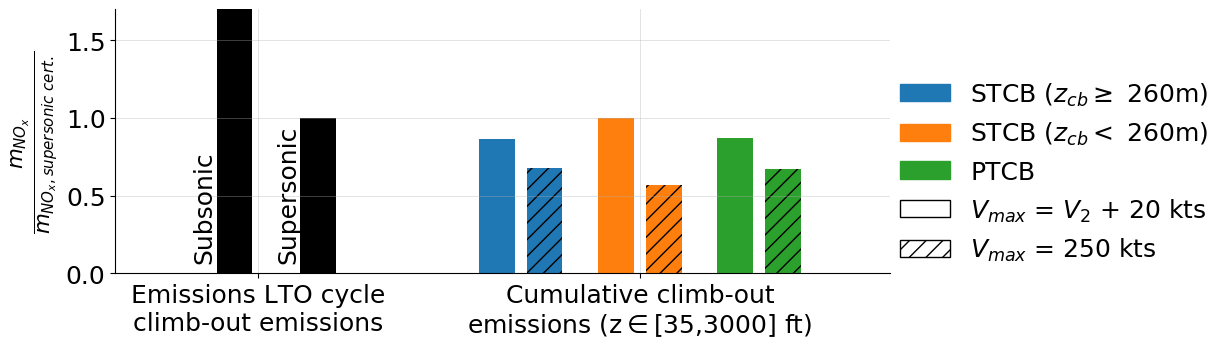

In [46]:
fig, ax = plt.subplots(1,1, figsize=(10,3.5))

colors = ['k', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, case in enumerate(case_lst):
    if i == 0:
        bar_t = ax.bar([0, 0.7, 2.2, 3.2, 4.2], mnox[case][:-1]/mnox[case][1], width=0.3, color=colors, hatch=hatch[i])
    elif i == 1:
        bar_t = ax.bar([0, 0.7, 2.6, 3.6, 4.6], mnox[case][:-1]/mnox[case][1], width=0.3, color=colors, hatch=hatch[i])

    if i == 0:
        ax.fill_between([18,19], [8,8], [9,9], color='tab:blue', label='STCB ($z_{cb} \geq$ 260m)', hatch=hatch[i])
        ax.fill_between([18,19], [8,8], [9,9], color='tab:orange', label='STCB ($z_{cb} <$ 260m)', hatch=hatch[i])
        ax.fill_between([18,19], [8,8], [9,9], color='tab:green', label='PTCB', hatch=hatch[i])
#         ax.fill_between([18,19], [8,8], [9,9], color='tab:red', label='PHLD', hatch=hatch[i])

ax.set_xlim([-1, 5.5])
ax.set_ylim([-0.0, 1.7])


ax.set_xticks([0, 0.7, 2, 3, 4, 5])
ax.set_xticks([0.2, 3.4])
ax.set_xticklabels(['Emissions LTO cycle\nclimb-out emissions', 'Cumulative climb-out\nemissions (z$\in$[35,3000] ft)'])
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = $V_2$ + 20 kts', hatch='')
ax.fill_between([18,19], [8,8], [9,9], facecolor='w', edgecolor="k", label='$V_{max}$ = 250 kts', hatch='//')

ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0), ncol=1, borderaxespad=0, frameon=False)

ax.set_ylabel(r'$\frac{m_{NO_x}}{m_{{NO_x}, supersonic\ cert.}}$', fontsize=22)

ax.annotate(xy=(-0.35, 0.1), s='Subsonic', rotation=90, color='k', fontsize=18)
ax.annotate(xy=( 0.35, 0.1), s='Supersonic', rotation=90, color='k', fontsize=18)